# Exploratory data analysis for all days ticket tracker
# plotsV0 -- create heat map of ticket availability

## Written by Nicholas Fasano
## Created on: 04/20/2023

In [48]:
# Load in python packages
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import datetime
import time


# import OS module
import os

# Load in all pickle files as dataframes and concatenate them

In [49]:
def convert_time(dt,delta):
    # input: 1) dt (datetime.time object)
    #        2) delta (int): minute incrment to round the time to (e.g. 1 rounds to nearest minute, 15 to nearest quarter hour)
    # otput  1) dt (datetime.time object): rounded to the nearest delta minute
    minute = dt.minute + dt.second/60
    dt = dt.replace(second=0)
    rounded_min = np.int(np.round(minute/delta,0)*delta)
    # must return a minute value between 0 and 59 and an hour value between 0 and 23
    if(rounded_min == 60):
        dt = dt.replace(minute=0)
        if(dt.hour == 23):
            dt = dt.replace(minute=59)
        else:
            dt = dt.replace(hour=dt.hour+1)
    else:
        dt = dt.replace(minute=rounded_min)
        
    return dt

# Load in all pickle files as dataframes and concatenate them

In [50]:
# execution time of this cell: ~30seconds, could be reduced by trimming the individual pickle files
Dir = 'C:\\Users\\Nick\\Documents\\DataScience\\Webscrapers\\colosseum\\pickle_files\\'

# load in .pkl files, filtering all files that dont have _all_days substring.
file_list = [f for f in os.listdir(Dir) if os.path.isfile(Dir+'/'+f) and '_all_days' in f and '.pkl' in f] 

df = []
for j in range(len(file_list)):
    df.append(pd.read_pickle(Dir + file_list[j]))
df = pd.concat(df) 

df.head()



day                        04/16/2023                                      \
entryTime                       08:00 08:05 08:10 08:15 08:20 08:25 08:30   
05/05/2023_23:08:43               NaN   NaN   NaN   NaN   NaN   NaN   NaN   
05/05/2023_23:15:05_FEUA_         NaN   NaN   NaN   NaN   NaN   NaN   NaN   
05/05/2023_23:15:34_FEA_          NaN   NaN   NaN   NaN   NaN   NaN   NaN   
05/05/2023_23:15:53_FEUAG_        NaN   NaN   NaN   NaN   NaN   NaN   NaN   
05/05/2023_23:16:09_RE_           NaN   NaN   NaN   NaN   NaN   NaN   NaN   

day                                           ... 06/14/2023              \
entryTime                  08:35 08:40 08:45  ...      22:15 22:20 22:25   
05/05/2023_23:08:43          NaN   NaN   NaN  ...        NaN   NaN   NaN   
05/05/2023_23:15:05_FEUA_    NaN   NaN   NaN  ...        NaN   NaN   NaN   
05/05/2023_23:15:34_FEA_     NaN   NaN   NaN  ...        NaN   NaN   NaN   
05/05/2023_23:15:53_FEUAG_   NaN   NaN   NaN  ...        NaN   NaN   NaN   
05/05/2023_23:16:09_RE_      NaN   NaN   NaN  ...        NaN   NaN   NaN   

day                                                                   
entryTime                  22:30 22:35 22:40 22:45 22:50 22:55 Color  
05/05/2023_23:08:43          NaN   NaN   NaN   NaN   NaN   NaN   NaN  
05/05/2023_23:15:05_FEUA_    NaN   NaN   NaN   NaN   NaN   NaN  grey  
05/05/2023_23:15:34_FEA_     NaN   NaN   NaN   NaN   NaN   NaN  grey  
05/05/2023_23:15:53_FEUAG_   NaN   NaN   NaN   NaN   NaN   NaN  grey  
05/05/2023_23:16:09_RE_      NaN   NaN   NaN   NaN   NaN   NaN  grey  

[5 rows x 10860 columns]

# Data preprocessing to create heatmaps

## 1) Remove days befire 04/21/2023 (that was the day I started to webscrape the data)

In [51]:
col_remove = []
for j in range(len(df.columns)):
    a = datetime.datetime.strptime(df.columns[j][0],'%m/%d/%Y').date()
    if(a < datetime.date(2023, 4, 21)):
        col_remove.append(df.columns[j])
df = df.drop(col_remove,axis=1)


## 2) Create lists of different possible indices names

In [52]:
# query date, query time, and ticket type
orig_index = df.index 

# query date only
date_index = [datetime.datetime.strptime(jdate[0:jdate.find('_')],'%m/%d/%Y').date() for jdate in df.index]

# query time only
time_index = [datetime.time(int(jtime[jtime.find('_')+1:jtime.find('_')+3]),int(jtime[jtime.find('_')+4:jtime.find('_')+6]),int(jtime[jtime.find('_')+7:jtime.find('_')+9])) for jtime in df.index]

# ticket type only
tick_index = [jtick[jtick.find('_')+10:-1] for jtick in df.index] 

## 3) Find ticket avialbility num_days after query date 

In [53]:
num_days = 7

df2 = []
search_dates = list(set(date_index))
for j in range(len(search_dates)):
    target_date = search_dates[j] + datetime.timedelta(days=num_days)
    col_keep = [jCol for jCol in df.columns if datetime.datetime.strptime(jCol[0],'%m/%d/%Y').date() == target_date]
    df2.append(df[col_keep].copy())
    df2[j].columns = df2[j].columns.get_level_values(1)
    df2[j]['search_date'] = date_index
    df2[j]['query_date'] = [target_date]*len(date_index)
    df2[j] = df2[j].query('search_date == @search_dates[@j]')
    
df2 = pd.concat(df2) 




## 4) Select rows based on ticket type and ticket availability, then create times index

In [54]:

df2['ticket_type'] = [ht[ht.find('_')+10:-1] for ht in df2.index]
df2 = df2.query('ticket_type == "FEA" or ticket_type == "FEUA" or ticket_type == "FEUAG"')
df2 = df2.drop(['ticket_type','search_date','query_date'],axis=1)

# retain only rows where day was green
df2 = df2[df2['Color'] == 'green'].drop(['Color'],axis=1)

# retain only times slots where at least one ticket was available
df2 = df2[df2.columns[df2.sum() > 0]]

# convert sparse dataframe to dense dataframe
df2 = df2.fillna(0).sparse.to_dense()


# add time and ticket type information from index
df2['times'] = [jind[jind.find(':')-2:jind.find(':')+6] for jind in df2.index]
df2['times'] = pd.to_datetime(df2['times']).dt.time
df2 = df2.set_index('times')

## 5) group nearby query times (by max) and ticket entry times (by sum)

In [55]:
# create copy of df
df_final = df2.copy()

# time window to group query times and ticket times
delta_min_ticket = 30 # minute
delta_min_query = 30 # minute


# ===========================================

# group ticket entry times by summing ticket counts within 30 minute preiods
timeLst = [datetime.time(hour=int(jtime[0:jtime.find(':')]),minute=int(jtime[3:])) for jtime in df_final.columns]
timeLst = [convert_time(jtime,delta_min_ticket) for jtime in timeLst]
df_final.columns = timeLst
df_final = df_final.groupby(df_final.columns,axis=1).sum()

# group query times by taking the max ticket count over a 30 minute period
df_final['times2'] = [convert_time(jtimes,delta_min_query) for jtimes in df_final.index]
df_final = df_final.loc[df_final.sum(axis=1) > 0]
df_final = df_final.groupby('times2').max().copy()

# ===========================================

# zero fill query times according to grouped interval
timeLst = [str(i*datetime.timedelta(minutes=delta_min_query)) for i in range(0*60//delta_min_query,23*60//delta_min_query)]
timeLst = ['0' + time[:-3] if ':' in time[0:2] else time[:-3] for time in timeLst ]
timeLst = [datetime.time(hour=int(jtime[0:jtime.find(':')]),minute=int(jtime[3:])) for jtime in timeLst]
df_final = df_final.join(pd.DataFrame(index=timeLst),on=df_final.index,how='outer',sort=True).set_index('key_0')
df_final.index.rename('times2',inplace=True)

# zero fill ticket entry times according to grouped interval
timeLst = [str(i*datetime.timedelta(minutes=delta_min_ticket)) for i in range(9*60//delta_min_ticket,18*60//delta_min_ticket)]
timeLst = ['0' + time[:-3] if ':' in time[0:2] else time[:-3] for time in timeLst ]
timeLst = [datetime.time(hour=int(jtime[0:jtime.find(':')]),minute=int(jtime[3:])) for jtime in timeLst]
for jtime in timeLst:
    if(jtime not in list(df_final.columns)):
        df_final[jtime] = np.nan
        
# sort query in ascending time order
df_final = df_final.reindex(sorted(df_final.columns), axis=1)


# convert index from local time ([EST]) to Rome time ([CET])
df_final.index = [datetime.datetime(1,1,1,jtime.hour,jtime.minute,jtime.second) + datetime.timedelta(hours=6) for jtime in df_final.index]
df_final.index = [jtime.time() for jtime in df_final.index]

# Finally create heatmap

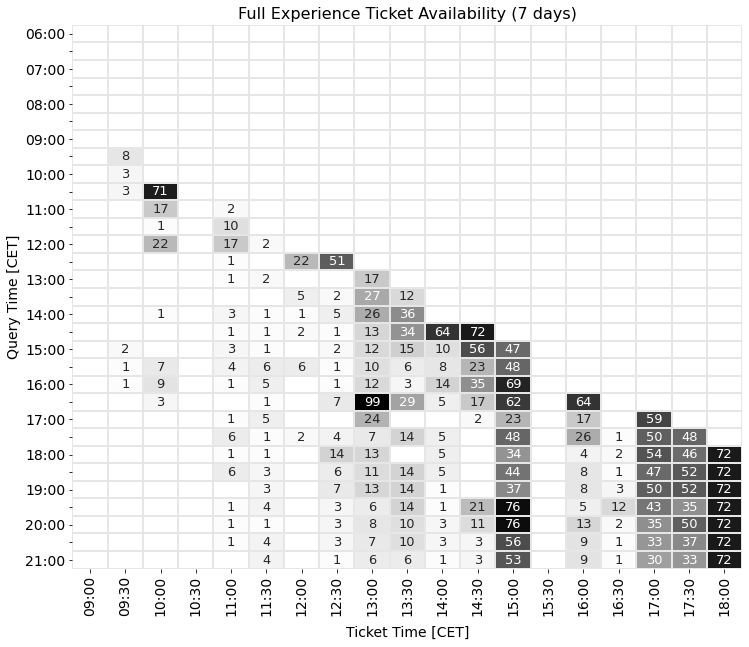

In [56]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(data=df_final.iloc[0:31].replace(0,np.nan),vmin=0,vmax=80,cmap=sns.color_palette("gray_r", as_cmap=True),
            cbar=False,annot=True,linewidth=1,linecolor=[0.9,0.9,0.9],fmt='g',annot_kws={"size":13})

temp = ax.get_yticklabels()
temp = [jtemp.get_text()[0:5] for jtemp in temp]
temp[1::2] = ['']*len(temp[1::2])
ax.set_yticklabels(temp,fontdict={'fontsize':14});

temp = ax.get_xticklabels()
temp = [jtemp.get_text()[0:5] for jtemp in temp]
ax.set_xticklabels(temp,fontdict={'fontsize':14});

ax.set_xlabel("Ticket Time [CET]",fontdict={'fontsize':14},labelpad=10)
ax.set_ylabel("Query Time [CET]",fontdict={'fontsize':14});
ax.set_title("Full Experience Ticket Availability (" + str(nDays) + " days)",fontdict={'fontsize':16});

# plt.savefig('AllDays_PlotsV0\RegularExperience_'+str(nDays)+'days.png', dpi=300)
# ax.set_ylim(20,0)